In [8]:
!pip install seaborn
!pip install formulaic
!pip install numpy

In [9]:
import seaborn as sns
import seaborn.objects as so

from scipy import stats
import numpy as np

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from formulaic import model_matrix

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios


In [10]:
def generar_datos(n=1000, amin=0, amax=20, bmin=5, bmax=20, seed=2906):
    np.random.seed(seed)
    brange = bmax - bmin
    a = stats.uniform.rvs(size=n, loc=amin, scale=amax - amin)
    b = stats.norm.rvs(size=n, loc=bmin + brange / 2, scale=brange / 8)
    eps = stats.norm.rvs(size=n, loc=0, scale=4)
    y = 1 + 3 * a - 2 * b + 1.5 * a * b - 0.8 * a**2 + 0.6 * b**2 + eps
    return pd.DataFrame({"a": a, "b": b}), pd.Series(y)


X, y = generar_datos()

In [11]:
X

,a,b
0,8.734133,15.394511
1,13.034632,12.525557
2,17.034105,10.551190
3,10.817888,15.382497
4,9.217678,13.748394
...,...,...
995,8.671706,12.553847
996,6.947835,8.640205
997,4.878641,14.271576
998,11.313032,16.268229


In [12]:
y

0      280.324677
1      216.688679
2      131.789786
3      303.421562
4      235.852460
          ...    
995    195.343680
996    102.264704
997    200.028047
998    333.430498
999    110.685708
Length: 1000, dtype: float64

In [5]:
# Graficamos la variable respuesta en funcion de las explicativas, en dos gráficos separados

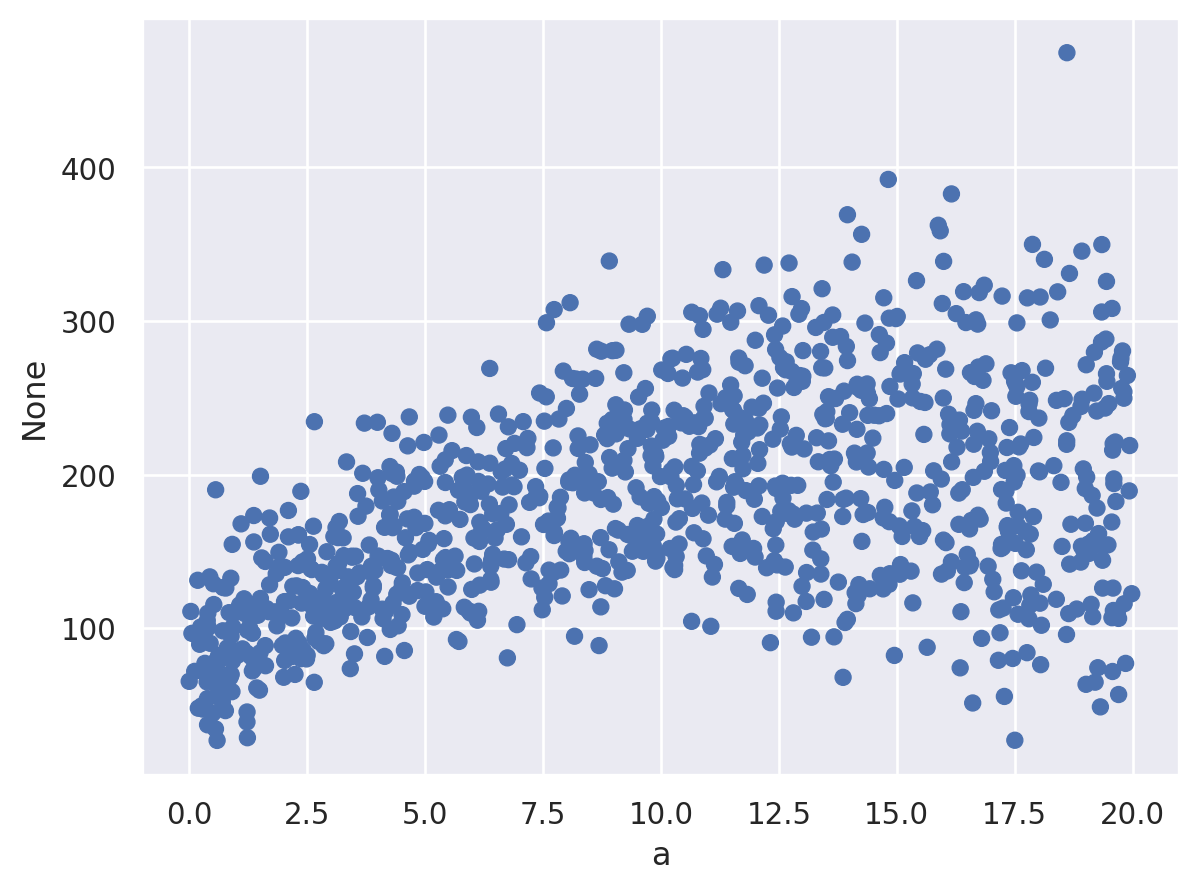

In [13]:
(
    so.Plot(x = X.a, y = y)
    .add(so.Dot())
)

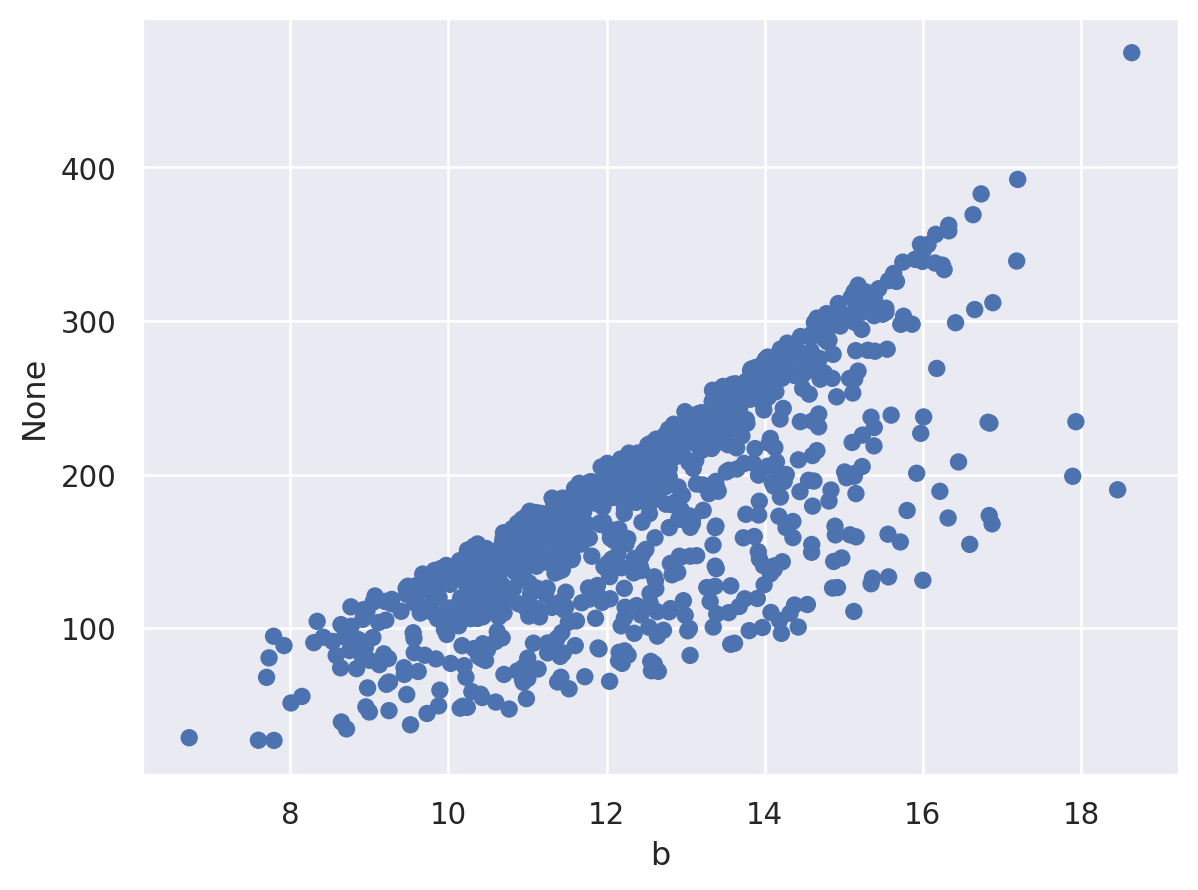

In [14]:
(
    so.Plot(x = X.b, y = y)
    .add(so.Dot())
)

In [15]:
# Probamos primero un modelo lineal
test_split = 0.95
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)

In [16]:
modeloLineal1 = LinearRegression()
modeloLineal1.fit(X_train, y_train)

LinearRegression()

In [17]:
# Guardamos los coeficientes en forma prolija
beta1 = pd.Series(modeloLineal1.coef_, index=X_train.columns)
beta1["intercept"] = modeloLineal1.intercept_
beta1

a              5.743446
b             30.165530
intercept   -250.365724
dtype: float64

In [18]:
# Calculando el ECM en entrenamiento y testeo

# ECM train
y_pred = modeloLineal1.predict(X_train)
ecm = mean_squared_error(y_train, y_pred)
print('Raiz cuadarada del ECM en entrenamiento: ', np.sqrt(ecm))

# ECM test
y_pred = modeloLineal1.predict(X_test)
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadarada del ECM en testeo: ', np.sqrt(ecm))

Raiz cuadarada del ECM en entrenamiento:  30.274636302109332
Raiz cuadarada del ECM en testeo:  30.446956812688764


## Análisis de residuos

Llamamos residuo al error en la predicción, es decir la diferencia entre el valor real y el valor predicho (y - y_pred).

Queremos ver si hay estructura en los residuos o parecen aleatorios.

Si hay estructura significa que hay alguna relación que no estamos teniendo en cuenta en el modelo.



In [19]:
# Ponemos todo en un solo DataFrame
# Podemos usar también pd.concat, pero tenemos que tener cuidado con los índices!
df_test = X_test.copy()
df_test["y"] = y_test
df_test["y_pred"] = y_pred
df_test["resid"] = df_test["y"] - df_test["y_pred"]
df_test.head()

,a,b,y,y_pred,resid
928,0.035305,15.126378,110.858662,206.132257,-95.273595
233,8.245538,13.327013,216.979295,199.008478,17.970817
62,3.296314,11.122261,112.620254,104.075372,8.544882
996,6.947835,8.640205,102.264704,50.175162,52.089542
81,7.996455,14.233652,243.056966,224.927139,18.129827


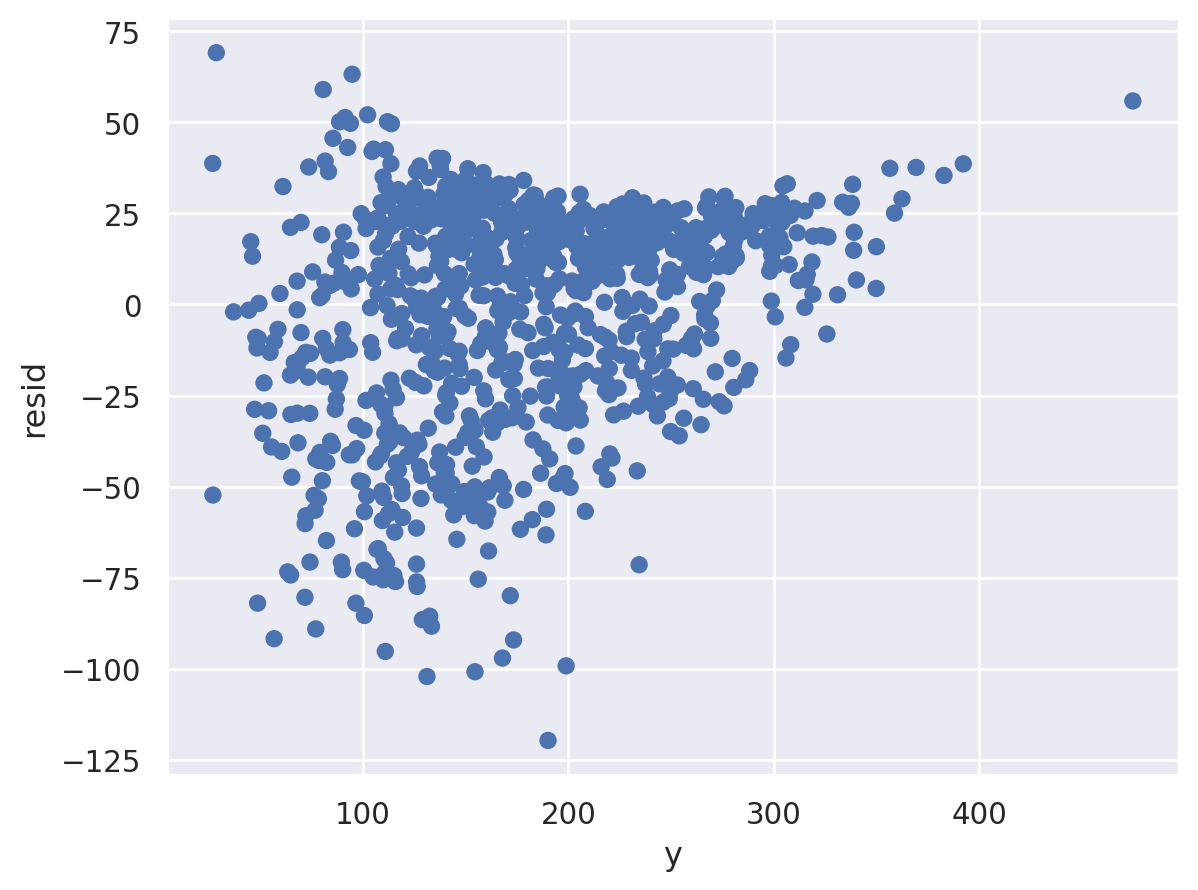

In [20]:
# Residuos en función de y
(
    so.Plot(x = df_test.y, y = df_test.resid)
    .add(so.Dot())
)

In [281]:
# Esto nos muestra que estamos prediciendo por abajo en los valores grandes de y, pero no hay mucho que podamos hacer porque no conocemos y.

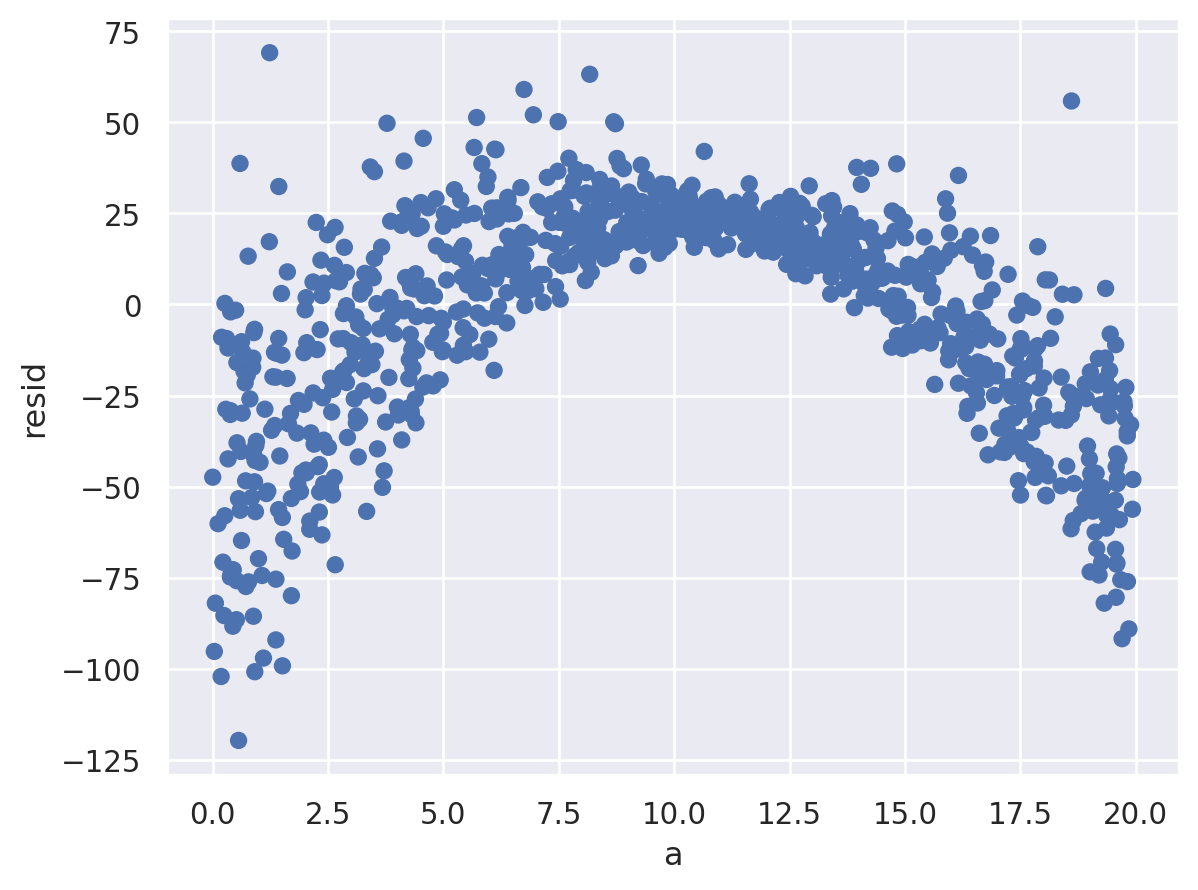

In [21]:
# Residuos en función de a
(
    so.Plot(x = df_test.a, y = df_test.resid)
    .add(so.Dot())
)

In [16]:
# Que sugiere esto?

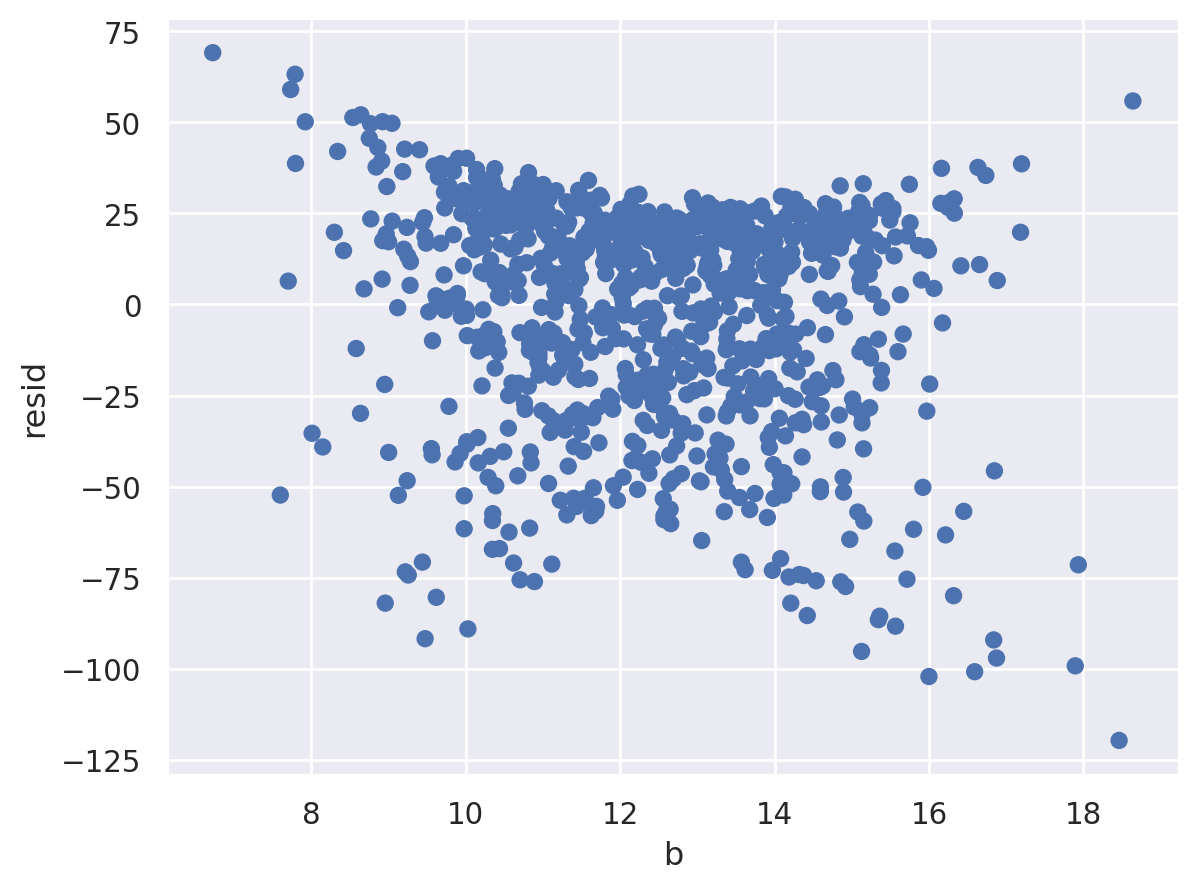

In [22]:
# Residuos en función de b
(
    so.Plot(x = df_test.b, y = df_test.resid)
    .add(so.Dot())
)

In [285]:
# No vemos mucha estructura acá, o es más dificil de saber qué hacer a partir de estos residuos.

In [23]:
# Comenzamos por agregar un término cuadrático en a.
formula = "~ poly(a, 2) + b"  # Esto aplica una normalización para evitar valores muy grandes
X_train2 = model_matrix(formula, data= X_train)
X_train2.head()

,Intercept,"poly(a, 2)[1]","poly(a, 2)[2]",b
725,1.0,0.047224,-0.130919,13.774746
285,1.0,0.205975,0.161715,9.566928
466,1.0,-0.221671,0.216577,8.710858
458,1.0,0.019214,-0.144195,14.634917
279,1.0,0.034110,-0.138567,14.694275


In [31]:
# Ajustamos
modeloLineal2 = LinearRegression()
modeloLineal2.fit(X_train2, y_train)

# Calculando el ECM en entrenamiento

# ECM train
y_pred2 = modeloLineal2.predict(X_train2)
ecm = mean_squared_error(y_train, y_pred2)
print('Raiz cuadarada del ECM en entrenamiento: ', np.sqrt(ecm))

Raiz cuadarada del ECM en entrenamiento:  18.608885178444307


In [32]:
# Como calculamos las predicciones? Tenemos que aplicar la misma transformación en testeo!
# La salida de formulaic no es solo la matriz, tambien guarda información de la transforamción
X_train2.model_spec

ModelSpec(formula=1 + poly(a, 2) + b, materializer='pandas', materializer_params={}, ensure_full_rank=True, na_action=<NAAction.DROP: 'drop'>, output='pandas', cluster_by=<ClusterBy.NONE: 'none'>, structure=[EncodedTermStructure(term=1, scoped_terms=[1], columns=['Intercept']), EncodedTermStructure(term=poly(a, 2), scoped_terms=[poly(a, 2)], columns=['poly(a, 2)[1]', 'poly(a, 2)[2]']), EncodedTermStructure(term=b, scoped_terms=[b], columns=['b'])], transform_state={'poly(a, 2)': {'alpha': {0: np.float64(9.474076086021046), 1: np.float64(9.546505700137041)}, 'norms2': {1: np.float64(1618.1201149565222), 0: np.float64(50.0), 2: np.float64(48700.04418043807)}}}, encoder_state={'poly(a, 2)': (<Kind.NUMERICAL: 'numerical'>, {}), 'b': (<Kind.NUMERICAL: 'numerical'>, {})})

In [33]:
ms = X_train2.model_spec

In [34]:
# Ahora podemos aplicar esas especificaciones a cualquier DataFrame! 
# En este caso seria un error aplicar la misma "fórmula", necesitamos aplicar las mismas transformaciones
X_test2 = ms.get_model_matrix(X_test)
X_test2

,Intercept,"poly(a, 2)[1]","poly(a, 2)[2]",b
928,1.0,-0.234644,0.260157,15.126378
233,1.0,-0.030541,-0.139405,13.327013
62,1.0,-0.153577,0.028321,11.122261
996,1.0,-0.062801,-0.116900,8.640205
81,1.0,-0.036733,-0.136269,14.233652
...,...,...,...,...
25,1.0,0.211994,0.180083,12.496378
659,1.0,0.035257,-0.137999,10.774004
601,1.0,-0.135581,-0.010072,14.837027
889,1.0,0.010255,-0.146012,10.311655


In [35]:
# Ahora si podemos calcular las predicciones en testeo

# Calculando el ECM en testeo

# ECM test
y_pred2 = modeloLineal2.predict(X_test2)
ecm = mean_squared_error(y_test, y_pred2)
print('Raiz cuadarada del ECM en testeo: ', np.sqrt(ecm))

Raiz cuadarada del ECM en testeo:  18.101649314370388


In [24]:
# Analizamos nuevamente los residuos

In [36]:
df_test2 = X_test.copy()
df_test2["y"] = y_test # No necesitamos las variables generadas
df_test2["y_pred"] = y_pred2
df_test2["resid"] = df_test2["y"] - df_test2["y_pred"]
df_test2.head()

,a,b,y,y_pred,resid
928,0.035305,15.126378,110.858662,151.103573,-40.244911
233,8.245538,13.327013,216.979295,220.612340,-3.633045
62,3.296314,11.122261,112.620254,103.636815,8.983440
996,6.947835,8.640205,102.264704,83.948024,18.316680
81,7.996455,14.233652,243.056966,242.834034,0.222932


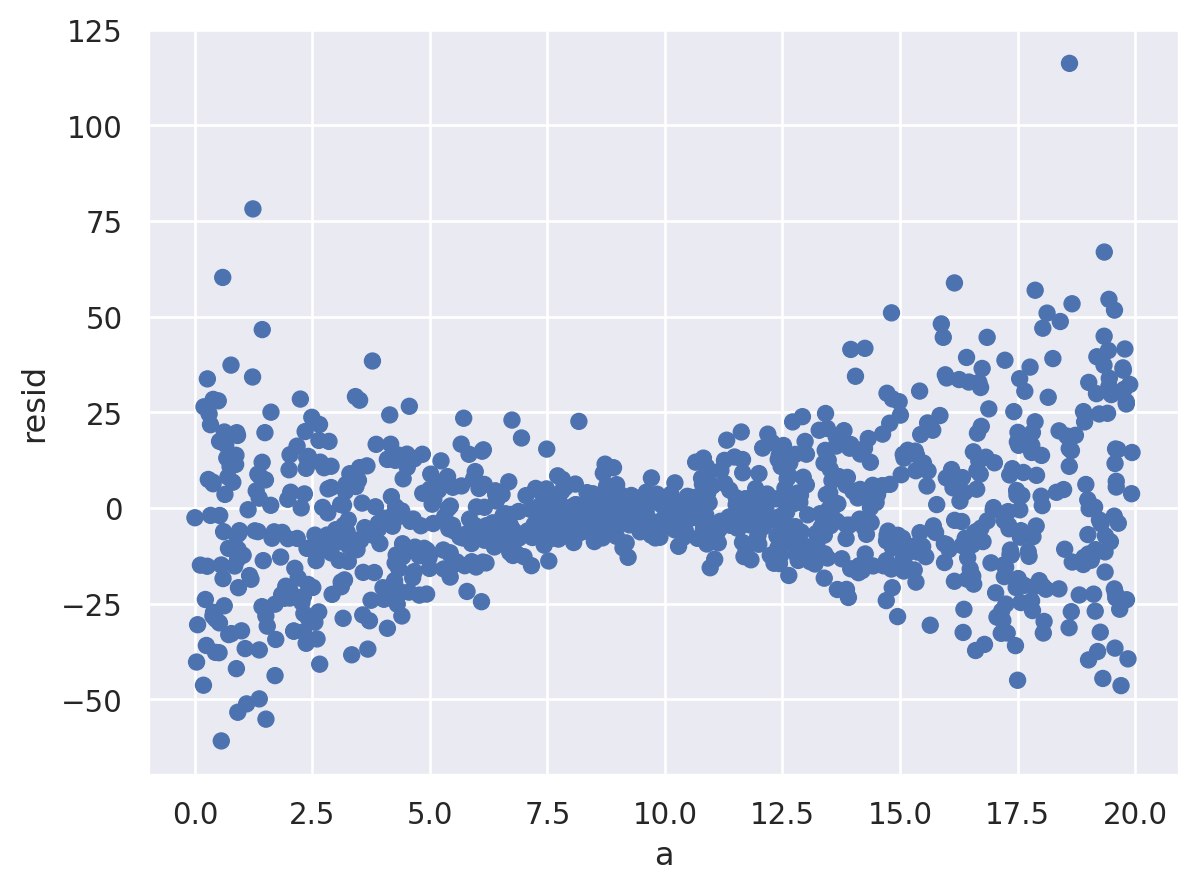

In [37]:
# Residuos en función de a
(
    so.Plot(x = df_test2.a, y = df_test2.resid)
    .add(so.Dot())
)

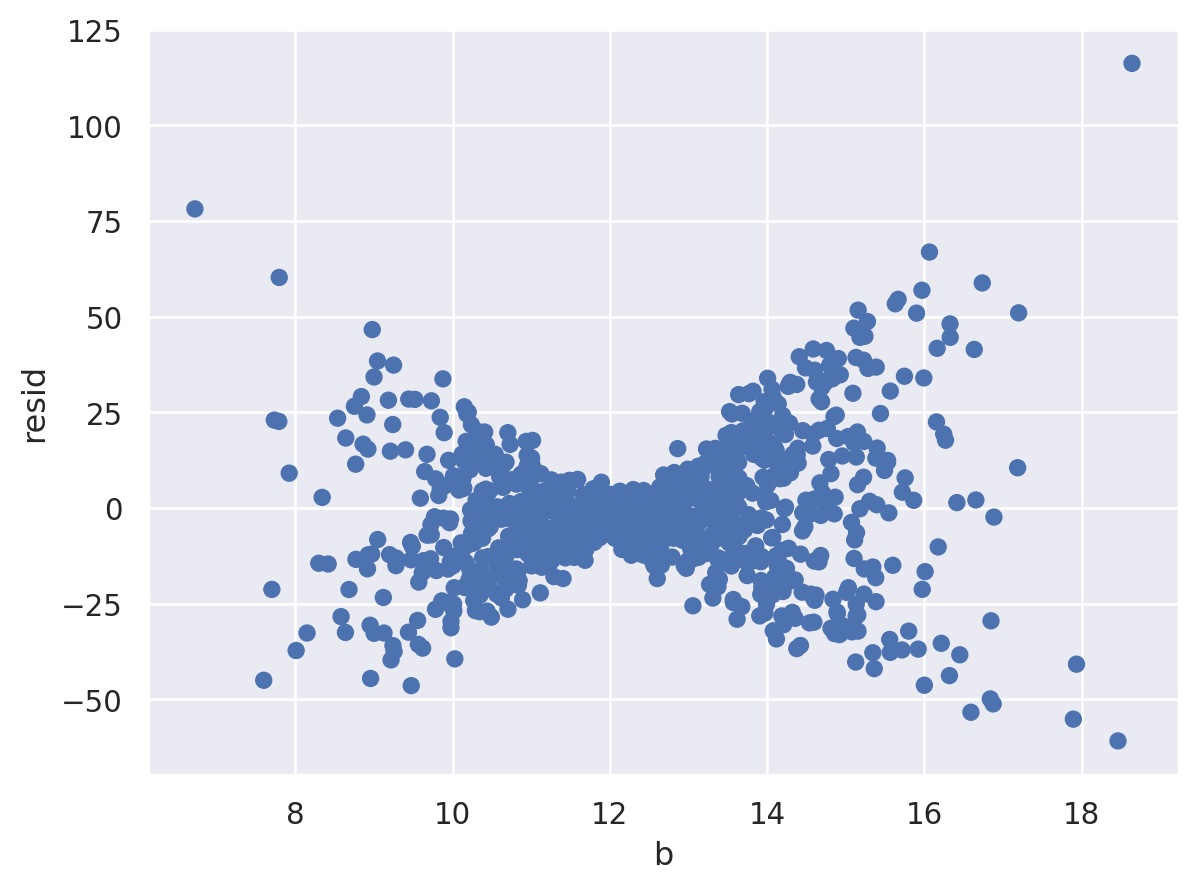

In [38]:
# Residuos en función de b
(
    so.Plot(x = df_test2.b, y = df_test2.resid)
    .add(so.Dot())
)

In [39]:
# Agregamos interacciones
# Comenzamos por agregar un término cuadrático en a.
formula = "~ poly(a, 2) * b"  # Esto aplica una normalización para evitar valores muy grandes
X_train3 = model_matrix(formula, data= X_train)
X_train3.head()

,Intercept,"poly(a, 2)[1]","poly(a, 2)[2]",b,"poly(a, 2)[1]:b","poly(a, 2)[2]:b"
725,1.0,0.047224,-0.130919,13.774746,0.650499,-1.803382
285,1.0,0.205975,0.161715,9.566928,1.970549,1.547116
466,1.0,-0.221671,0.216577,8.710858,-1.930941,1.886570
458,1.0,0.019214,-0.144195,14.634917,0.281197,-2.110277
279,1.0,0.034110,-0.138567,14.694275,0.501227,-2.036141


In [40]:
# Ajustamos
modeloLineal3 = LinearRegression()
modeloLineal3.fit(X_train3, y_train)

# Calculando el ECM en entrenamiento

# ECM train
y_pred3 = modeloLineal3.predict(X_train3)
ecm = mean_squared_error(y_train, y_pred3)
print('Raiz cuadarada del ECM en entrenamiento: ', np.sqrt(ecm))

Raiz cuadarada del ECM en entrenamiento:  4.913223817048088


In [41]:
# Calculamos el ECM en testeo

ms = X_train3.model_spec

# Generamos la matriz
X_test3 = ms.get_model_matrix(X_test)
X_test3.head()

,Intercept,"poly(a, 2)[1]","poly(a, 2)[2]",b,"poly(a, 2)[1]:b","poly(a, 2)[2]:b"
928,1.0,-0.234644,0.260157,15.126378,-3.549319,3.935231
233,1.0,-0.030541,-0.139405,13.327013,-0.407020,-1.857858
62,1.0,-0.153577,0.028321,11.122261,-1.708122,0.314988
996,1.0,-0.062801,-0.116900,8.640205,-0.542617,-1.010038
81,1.0,-0.036733,-0.136269,14.233652,-0.522846,-1.939609


In [42]:
# ECM test
y_pred3 = modeloLineal3.predict(X_test3)
ecm = mean_squared_error(y_test, y_pred3)
print('Raiz cuadarada del ECM en testeo: ', np.sqrt(ecm))

Raiz cuadarada del ECM en testeo:  4.939816932828776


In [43]:
df_test3 = X_test.copy()
df_test3["y"] = y_test # No necesitamos las variables generadas
df_test3["y_pred"] = y_pred3
df_test3["resid"] = df_test3["y"] - df_test3["y_pred"]
df_test3.head()

,a,b,y,y_pred,resid
928,0.035305,15.126378,110.858662,109.263562,1.595100
233,8.245538,13.327013,216.979295,217.799284,-0.819989
62,3.296314,11.122261,112.620254,110.567786,2.052469
996,6.947835,8.640205,102.264704,92.281895,9.982809
81,7.996455,14.233652,243.056966,238.396043,4.660922


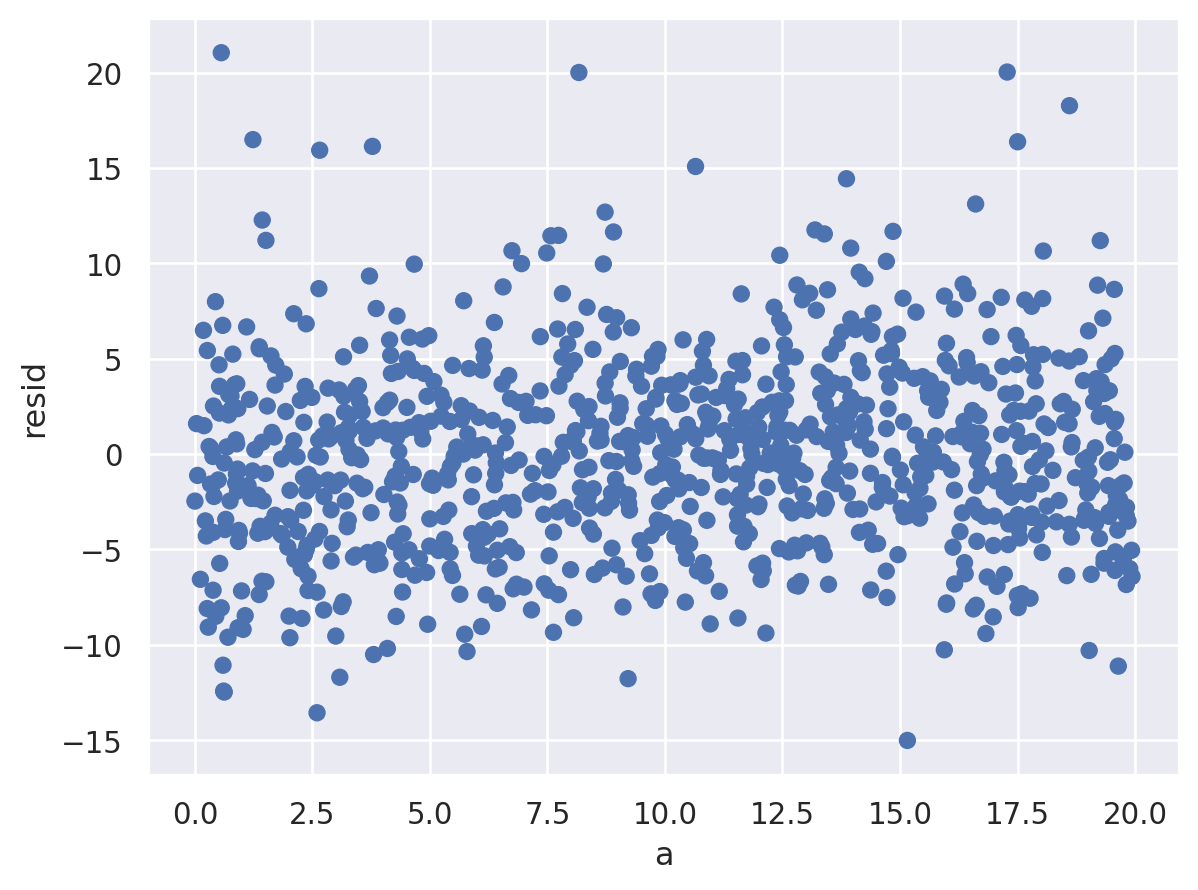

In [44]:
# Residuos en función de a
(
    so.Plot(x = df_test3.a, y = df_test3.resid)
    .add(so.Dot())
)

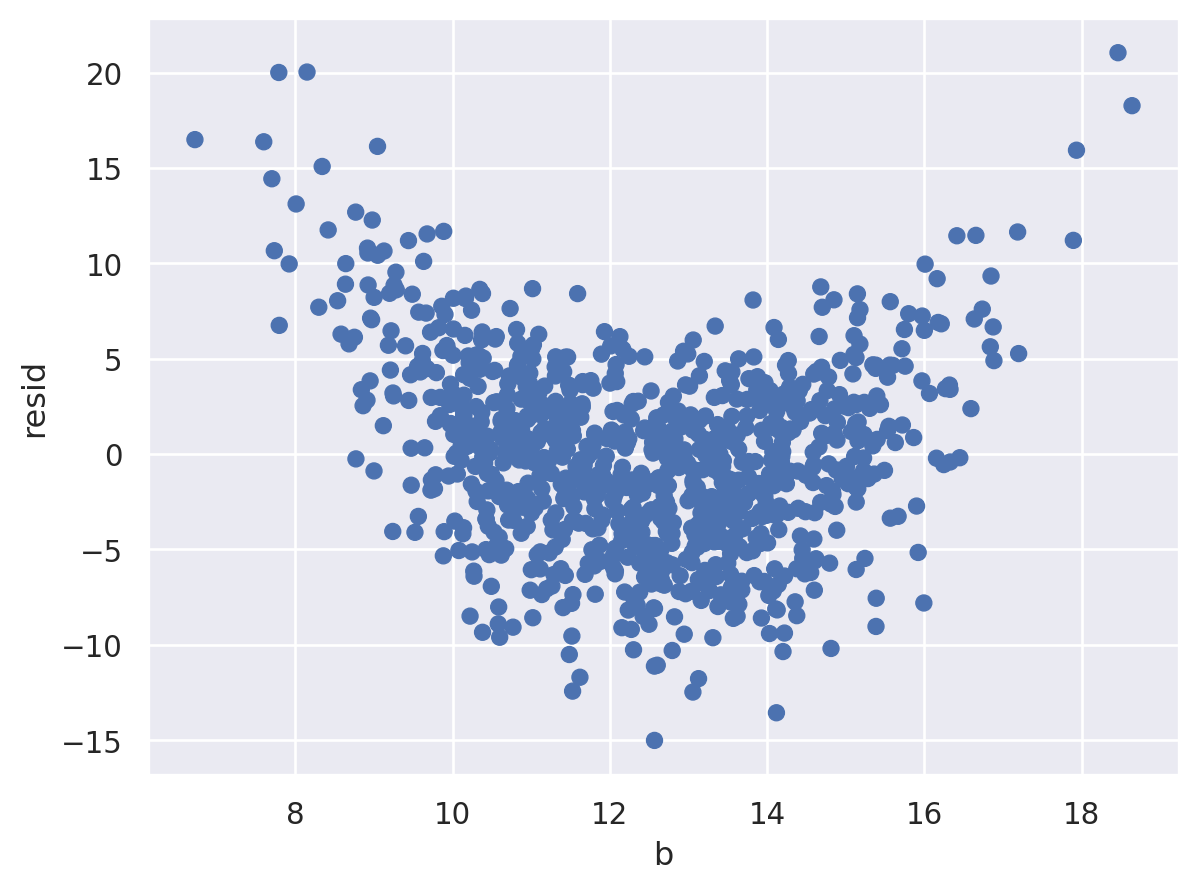

In [45]:
# Residuos en función de b
(
    so.Plot(x = df_test3.b, y = df_test3.resid)
    .add(so.Dot())
)

Podemos seguir agregando términos e interacciones de mayor grado. Vamos a hacer regresión Ridge para evitar el sobreajuste.Tenemos q sacar el intercept, para no penalizarlo xq queremos q el modelo sea constante y q no tienda a 0. Xq formulaic no se relaciona con sk-learn. 

In [46]:
from sklearn.linear_model import Ridge

formula = "~ poly(a, 4) * poly(b, 4) - 1"
X_train4 = model_matrix(formula, data=X_train)
ms = X_train4.model_spec
X_train4

,"poly(a, 4)[1]","poly(a, 4)[2]","poly(a, 4)[3]","poly(a, 4)[4]","poly(b, 4)[1]","poly(b, 4)[2]","poly(b, 4)[3]","poly(b, 4)[4]","poly(a, 4)[1]:poly(b, 4)[1]","poly(a, 4)[2]:poly(b, 4)[1]",...,"poly(a, 4)[3]:poly(b, 4)[2]","poly(a, 4)[4]:poly(b, 4)[2]","poly(a, 4)[1]:poly(b, 4)[3]","poly(a, 4)[2]:poly(b, 4)[3]","poly(a, 4)[3]:poly(b, 4)[3]","poly(a, 4)[4]:poly(b, 4)[3]","poly(a, 4)[1]:poly(b, 4)[4]","poly(a, 4)[2]:poly(b, 4)[4]","poly(a, 4)[3]:poly(b, 4)[4]","poly(a, 4)[4]:poly(b, 4)[4]"
725,0.047224,-0.130919,-0.053448,0.107771,0.093091,-0.054081,-0.111446,0.025321,0.004396,-0.012187,...,0.002891,-0.005828,-0.005263,0.014590,0.005957,-0.012011,0.001196,-0.003315,-0.001353,0.002729
285,0.205975,0.161715,-0.018728,-0.188118,-0.226110,0.151763,0.012097,-0.202790,-0.046573,-0.036565,...,-0.002842,-0.028549,0.002492,0.001956,-0.000227,-0.002276,-0.041770,-0.032794,0.003798,0.038148
466,-0.221671,0.216577,-0.227397,0.191538,-0.291051,0.335165,-0.295115,0.241143,0.064517,-0.063035,...,-0.076216,0.064197,0.065418,-0.063915,0.067108,-0.056526,-0.053454,0.052226,-0.054835,0.046188
458,0.019214,-0.144195,0.010669,0.142032,0.158343,0.046156,-0.118970,-0.148434,0.003042,-0.022832,...,0.000492,0.006556,-0.002286,0.017155,-0.001269,-0.016897,-0.002852,0.021403,-0.001584,-0.021082
279,0.034110,-0.138567,-0.024041,0.128602,0.162846,0.054855,-0.115453,-0.159514,0.005555,-0.022565,...,-0.001319,0.007054,-0.003938,0.015998,0.002776,-0.014848,-0.005441,0.022103,0.003835,-0.020514
759,-0.013957,-0.145035,0.087114,0.131082,0.013608,-0.110917,-0.008060,0.134120,-0.000190,-0.001974,...,-0.009662,-0.014539,0.000112,0.001169,-0.000702,-0.001057,-0.001872,-0.019452,0.011684,0.017581
591,0.122108,-0.038931,-0.160108,-0.116689,0.042464,-0.098571,-0.052274,0.116920,0.005185,-0.001653,...,0.015782,0.011502,-0.006383,0.002035,0.008370,0.006100,0.014277,-0.004552,-0.018720,-0.013643
973,0.133751,-0.017242,-0.161313,-0.153928,0.070238,-0.077765,-0.088761,0.075047,0.009394,-0.001211,...,0.012545,0.011970,-0.011872,0.001530,0.014318,0.013663,0.010038,-0.001294,-0.012106,-0.011552
959,0.185840,0.104133,-0.088468,-0.231739,0.025218,-0.107086,-0.026341,0.130625,0.004687,0.002626,...,0.009474,0.024816,-0.004895,-0.002743,0.002330,0.006104,0.024275,0.013602,-0.011556,-0.030271
898,-0.038951,-0.135009,0.137581,0.088039,-0.263692,0.252068,-0.140541,-0.021138,0.010271,0.035601,...,0.034680,0.022192,0.005474,0.018974,-0.019336,-0.012373,0.000823,0.002854,-0.002908,-0.001861


Modelo Ridge(funcion de perdida) = ||y² - ŷ||² + alfa.||beta||²

In [60]:
# Para definir los alfas, podemos usar np.logspace (valores espaciados en progresión geométrica), datos distribuidos de forma constante en este caso cte geometrica.
np.logspace(0, 2, 5) #(desde numero a la exponente,hasta numero a la tal exponente', con 5 valores )

array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        ])

In [61]:
# Generamos un vector de alfas
alfas = np.logspace(-7, 1, 61)
alfas

array([1.00000000e-07, 1.35935639e-07, 1.84784980e-07, 2.51188643e-07,
       3.41454887e-07, 4.64158883e-07, 6.30957344e-07, 8.57695899e-07,
       1.16591440e-06, 1.58489319e-06, 2.15443469e-06, 2.92864456e-06,
       3.98107171e-06, 5.41169527e-06, 7.35642254e-06, 1.00000000e-05,
       1.35935639e-05, 1.84784980e-05, 2.51188643e-05, 3.41454887e-05,
       4.64158883e-05, 6.30957344e-05, 8.57695899e-05, 1.16591440e-04,
       1.58489319e-04, 2.15443469e-04, 2.92864456e-04, 3.98107171e-04,
       5.41169527e-04, 7.35642254e-04, 1.00000000e-03, 1.35935639e-03,
       1.84784980e-03, 2.51188643e-03, 3.41454887e-03, 4.64158883e-03,
       6.30957344e-03, 8.57695899e-03, 1.16591440e-02, 1.58489319e-02,
       2.15443469e-02, 2.92864456e-02, 3.98107171e-02, 5.41169527e-02,
       7.35642254e-02, 1.00000000e-01, 1.35935639e-01, 1.84784980e-01,
       2.51188643e-01, 3.41454887e-01, 4.64158883e-01, 6.30957344e-01,
       8.57695899e-01, 1.16591440e+00, 1.58489319e+00, 2.15443469e+00,
      

In [62]:
X_test4 = ms.get_model_matrix(X_test)

rmse_train = {}  # Resulta útil guardar los valores en un diccionario
rmse_test = {}
intercept = {}
for alfa in alfas:
    ridge = Ridge(alpha=alfa)
    ridge.fit(X_train4, y_train)
    rmse_train[alfa] =  np.sqrt(mean_squared_error(ridge.predict(X_train4), y_train))
    rmse_test[alfa] =  np.sqrt(mean_squared_error(ridge.predict(X_test4), y_test))
    intercept[alfa] = ridge.intercept_

In [63]:
# Convertimos a DataFrame para graficar
data = pd.DataFrame(
    {
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "intercept": intercept,
    }
).reset_index(names="alfa")
data

,alfa,rmse_train,rmse_test,intercept
0,1.000000e-07,3.364600,54.678571,181.886205
1,1.359356e-07,3.364600,54.663998,181.886617
2,1.847850e-07,3.364601,54.644203,181.887176
3,2.511886e-07,3.364601,54.617320,181.887934
4,3.414549e-07,3.364603,54.580824,181.888963
...,...,...,...,...
56,2.928645e+00,52.993918,52.125908,182.625924
57,3.981072e+00,56.995723,55.450214,182.614481
58,5.411695e+00,60.433698,58.294180,182.603356
59,7.356423e+00,63.292902,60.654105,182.593251


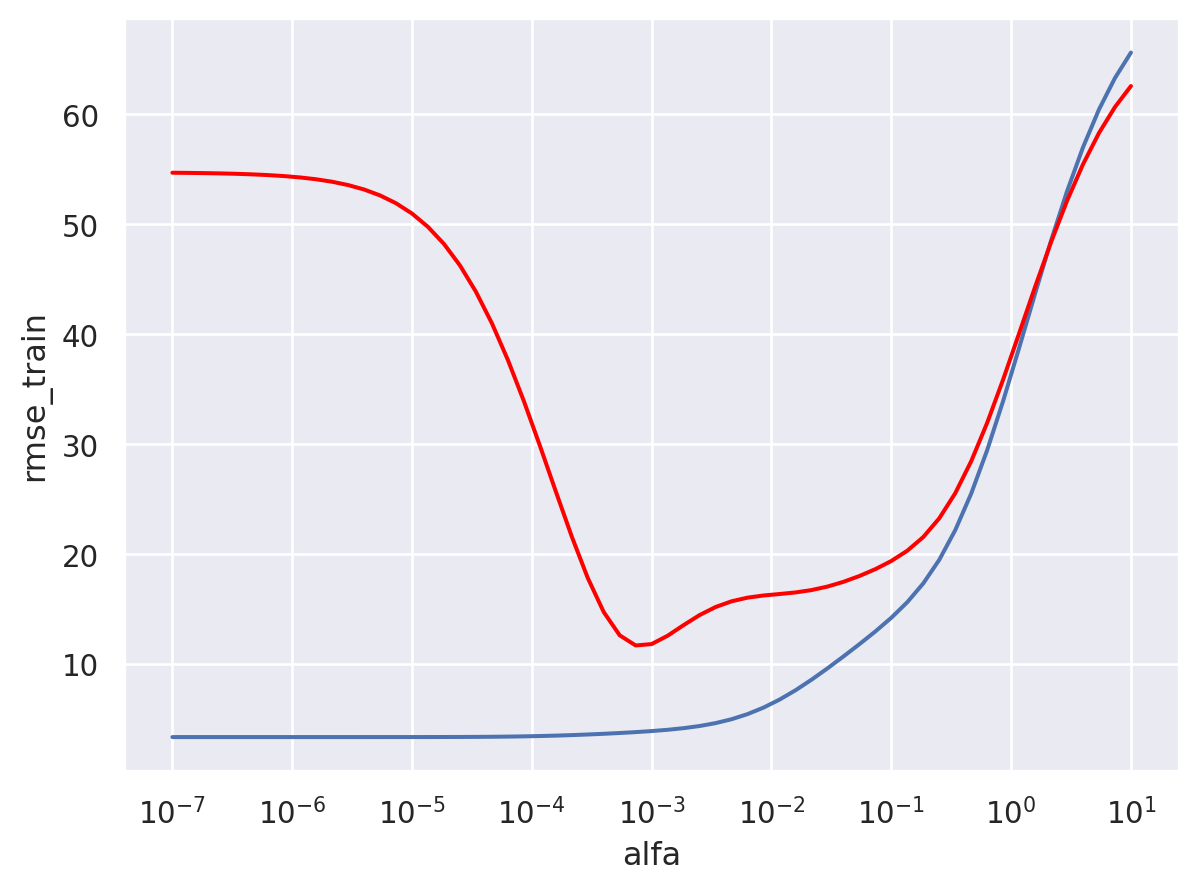

In [64]:
# Residuos en función de a
(
    so.Plot(data = data, x= "alfa").scale(x = "log")
    .add(so.Line(), y = "rmse_train")
    .add(so.Line(color = "red"), y = "rmse_test")
)

Errrores en testeo cuando metemos el alfa = nada, xq no sabemos cual nos conviene.
Errores cuando voy aumentando el alfa = q suban
En este caso entre 10^-3 y 10^-4 esta el mejor alfa

In [70]:
# Automatizamos la búsqueda con comandos de sklearn

In [71]:
# La primera opción es usar GridSearch

In [72]:
from sklearn.model_selection import GridSearchCV

alfas = np.logspace(-7, 1, 61)

param_grid = {"alpha": alfas}
gs = GridSearchCV(
    Ridge(),
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
)
gs.fit(X_train4, y_train)

gs.best_params_

{'alpha': np.float64(0.004641588833612782)}

In [75]:
# O podemos usar validazion cruzada específica de Ridge

In [76]:
modelo = linear_model.RidgeCV(alphas = alfas, cv = 5)
modelo.fit(X_train4, y_train)
modelo.alpha_

np.float64(0.00630957344480193)

In [77]:
# ECM train
y_pred = modelo.predict(X_train4)
ecm = mean_squared_error(y_train, y_pred)
print('Raiz cuadarada del ECM en entrenamiento: ', np.sqrt(ecm))

# ECM test
y_pred = modelo.predict(X_test4)
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadarada del ECM en testeo: ', np.sqrt(ecm))

Raiz cuadarada del ECM en entrenamiento:  5.45154945270216
Raiz cuadarada del ECM en testeo:  16.040922792387946


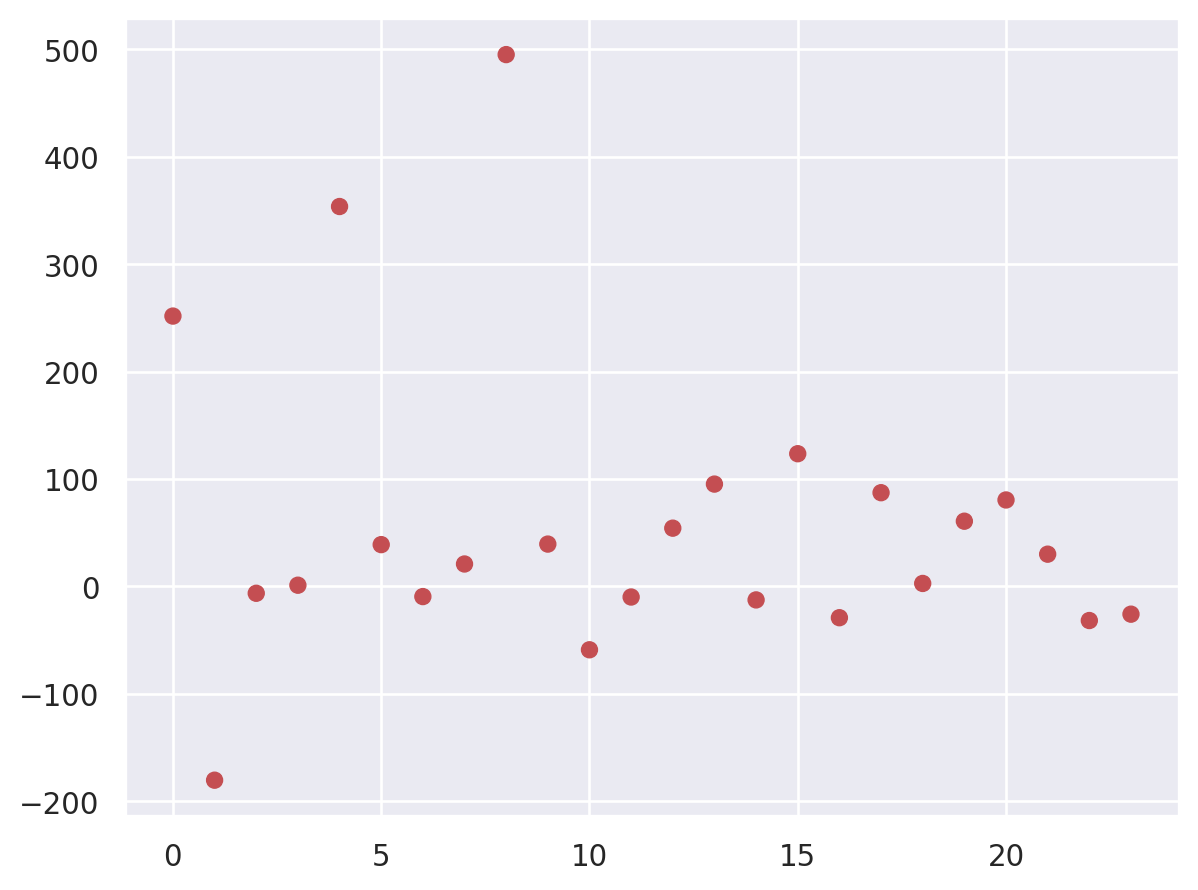

In [78]:
(
    so.Plot(x = np.arange(len(modelo.coef_)))
    .add(so.Dot(color = "r"), y = modelo.coef_)
)

In [79]:
# Miramos los coeficientes en forma prolija
beta1 = pd.Series(modelo.coef_, index=X_train4.columns)
beta1["intercept"] = modelo.intercept_
beta1

poly(a, 4)[1]                  251.653574
poly(a, 4)[2]                 -180.337270
poly(a, 4)[3]                   -6.361335
poly(a, 4)[4]                    1.146740
poly(b, 4)[1]                  353.628321
poly(b, 4)[2]                   38.920650
poly(b, 4)[3]                   -9.438755
poly(b, 4)[4]                   20.895507
poly(a, 4)[1]:poly(b, 4)[1]    495.033985
poly(a, 4)[2]:poly(b, 4)[1]     39.424643
poly(a, 4)[3]:poly(b, 4)[1]    -58.963670
poly(a, 4)[4]:poly(b, 4)[1]     -9.850133
poly(a, 4)[1]:poly(b, 4)[2]     54.242796
poly(a, 4)[2]:poly(b, 4)[2]     95.268164
poly(a, 4)[3]:poly(b, 4)[2]    -12.541478
poly(a, 4)[4]:poly(b, 4)[2]    123.535640
poly(a, 4)[1]:poly(b, 4)[3]    -29.106466
poly(a, 4)[2]:poly(b, 4)[3]     87.252156
poly(a, 4)[3]:poly(b, 4)[3]      2.782401
poly(a, 4)[4]:poly(b, 4)[3]     60.724368
poly(a, 4)[1]:poly(b, 4)[4]     80.488881
poly(a, 4)[2]:poly(b, 4)[4]     30.033537
poly(a, 4)[3]:poly(b, 4)[4]    -31.727286
poly(a, 4)[4]:poly(b, 4)[4]    -25

In [80]:
# O podemos usar Leave-One-Out
# En este esquema, la cantidad de pliegos es igual a la cantidad de observaciones!
modelo = linear_model.RidgeCV(alphas = alfas)
modelo.fit(X_train4, y_train)
modelo.alpha_

np.float64(0.001)

In [81]:
# ECM train
y_pred = modelo.predict(X_train4)
ecm = mean_squared_error(y_train, y_pred)
print('Raiz cuadarada del ECM en entrenamiento: ', np.sqrt(ecm))

# ECM test
y_pred = modelo.predict(X_test4)
ecm = mean_squared_error(y_test, y_pred)
print('Raiz cuadarada del ECM en testeo: ', np.sqrt(ecm))

Raiz cuadarada del ECM en entrenamiento:  3.9111926457531205
Raiz cuadarada del ECM en testeo:  11.822469338001973


In [82]:
modelo.coef_

array([ 254.52099754, -176.89319176,   -4.70681835,    5.58497252,
        358.50965651,   35.35533381,   -0.87047485,   17.45430678,
        698.42435886,  -29.23479441,  -63.78518538,  -11.74766217,
         40.86365844,   53.85889188,   27.11559217,  135.91817425,
          2.81434343,   54.97687432,  -34.85025308,   61.21343836,
         96.23564699,  -29.73780368,   43.57930846,  -47.23997166])

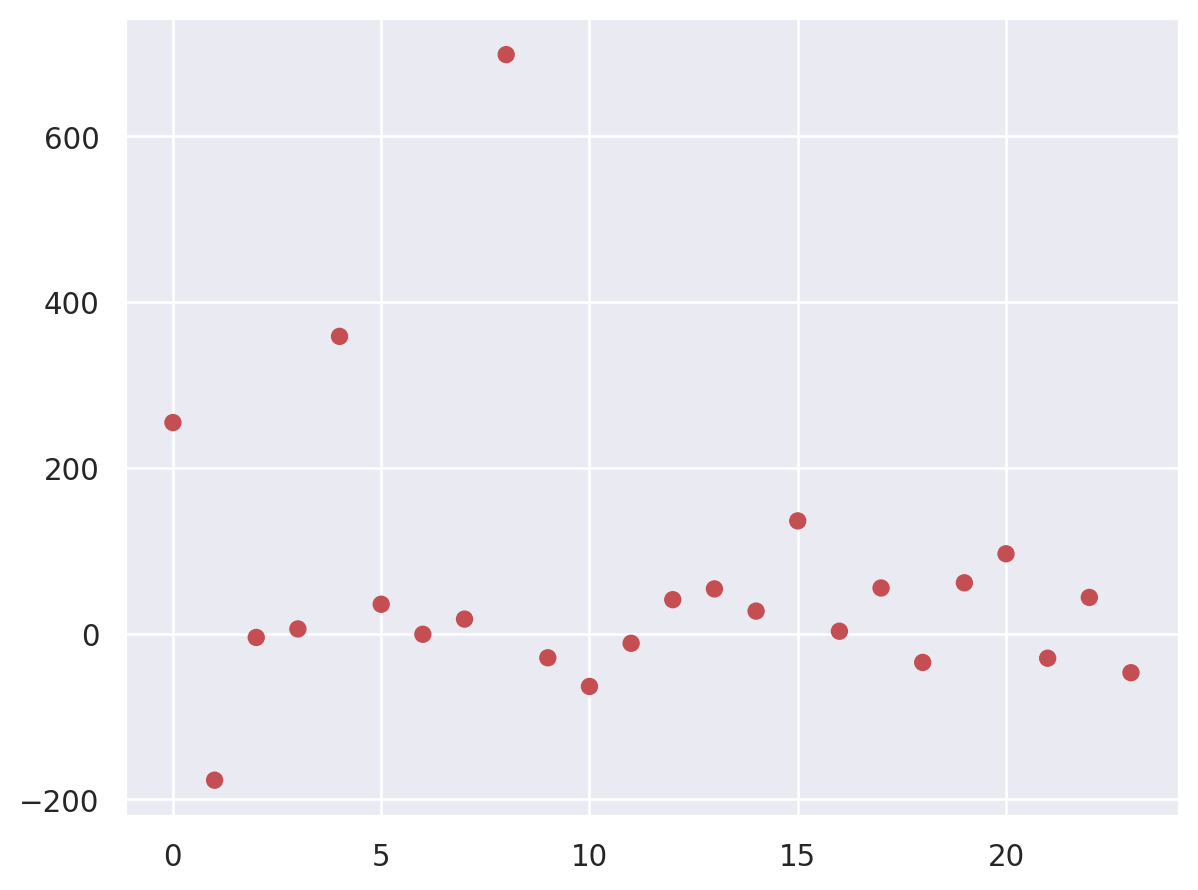

In [83]:
(
    so.Plot(x = np.arange(len(modelo.coef_)))
    .add(so.Dot(color = "r"), y = modelo.coef_)
)

In [84]:
# Miramos los coeficientes en forma prolija
beta1 = pd.Series(modelo.coef_, index=X_train4.columns)
beta1["intercept"] = modelo.intercept_
beta1

poly(a, 4)[1]                  254.520998
poly(a, 4)[2]                 -176.893192
poly(a, 4)[3]                   -4.706818
poly(a, 4)[4]                    5.584973
poly(b, 4)[1]                  358.509657
poly(b, 4)[2]                   35.355334
poly(b, 4)[3]                   -0.870475
poly(b, 4)[4]                   17.454307
poly(a, 4)[1]:poly(b, 4)[1]    698.424359
poly(a, 4)[2]:poly(b, 4)[1]    -29.234794
poly(a, 4)[3]:poly(b, 4)[1]    -63.785185
poly(a, 4)[4]:poly(b, 4)[1]    -11.747662
poly(a, 4)[1]:poly(b, 4)[2]     40.863658
poly(a, 4)[2]:poly(b, 4)[2]     53.858892
poly(a, 4)[3]:poly(b, 4)[2]     27.115592
poly(a, 4)[4]:poly(b, 4)[2]    135.918174
poly(a, 4)[1]:poly(b, 4)[3]      2.814343
poly(a, 4)[2]:poly(b, 4)[3]     54.976874
poly(a, 4)[3]:poly(b, 4)[3]    -34.850253
poly(a, 4)[4]:poly(b, 4)[3]     61.213438
poly(a, 4)[1]:poly(b, 4)[4]     96.235647
poly(a, 4)[2]:poly(b, 4)[4]    -29.737804
poly(a, 4)[3]:poly(b, 4)[4]     43.579308
poly(a, 4)[4]:poly(b, 4)[4]    -47